# Enforcement Pattern Analysis: LPR, AMP, and Ticket Relationships
Analyze aggregate patterns to understand enforcement dynamics and create features for predictive modeling.
## Key Questions:
1. **If I park without a permit in zone X at time Y for Z hours, what's my ticket risk?**
2. **Does higher occupancy (LPR scans) lead to more tickets?**
3. **What's the relationship between unpaid vehicles and enforcement?**
4. **How does AMP (paid parking) correlate with ticket probability?**
5. **Which zones/times have highest enforcement risk?**
6. **Can we predict enforcement intensity from occupancy patterns?**
7. **Does weather affect enforcement behavior?**
8. **How do enforcement patterns change over time (2022-2025)?**
These become **features for machine learning models**!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## Load Enforcement Data
We already created this in notebook 12 - it has zone-hour aggregates.

In [ ]:
# Load enforcement data (created in notebook 12)
# This already includes camera classification from notebook 16!
enforcement = pd.read_csv('../../data/processed/enforcement_full_extended.csv', parse_dates=['date', 'datetime'])
print(f"Enforcement data: {len(enforcement):,} zone-hour records")
print(f"Columns: {list(enforcement.columns)}")
print(f"\nDate range: {enforcement['date'].min()} to {enforcement['date'].max()}")
print(f"Zones: {enforcement['Zone'].nunique()}")
# Check if year feature is present
if 'year' in enforcement.columns:
    print(f"\n Year feature loaded")
    print(f"Year distribution:")
    for year, count in enforcement.groupby('year').size().items():
        print(f"  {year}: {count:,} records ({count/len(enforcement)*100:.1f}%)")
else:
    print(f"\n Year feature missing - extracting from datetime")
    enforcement['year'] = enforcement['datetime'].dt.year
    print(f"Year distribution:")
    for year, count in enforcement.groupby('year').size().items():
        print(f"  {year}: {count:,} records ({count/len(enforcement)*100:.1f}%)")
# Check if time_of_day_code is present
if 'time_of_day_code' not in enforcement.columns and 'time_of_day' in enforcement.columns:
    print(f"\n time_of_day_code missing - encoding from time_of_day")
    time_of_day_map = {
        'Afternoon': 0, 'Evening': 1, 'Late Night': 2, 'Morning': 3, 'Night': 4
    }
    enforcement['time_of_day_code'] = enforcement['time_of_day'].map(time_of_day_map)
    print(f" time_of_day_code encoded")
# Check if camera classification is present
if 'has_fixed_camera' in enforcement.columns:
    print(f"\n Camera classification loaded from notebook 16")
    print(f"  Zone-hours with fixed cameras: {enforcement['has_fixed_camera'].sum():,}")
    print(f"  Zones with cameras: {enforcement[enforcement['has_fixed_camera']==1]['Zone'].nunique()}")
    camera_zones = enforcement[enforcement['has_fixed_camera']==1]['Zone'].unique()
    if len(camera_zones) > 0:
        print(f"  Camera zones: {sorted(camera_zones)}")
else:
    print(f"\n Camera classification not found - run notebook 12 first")
# Basic statistics
print(f"\n{enforcement[['lpr_scans', 'amp_sessions', 'tickets_issued', 'unpaid_estimate', 'enforcement_rate']].describe()}")

Enforcement data: 730,800 zone-hour records
Columns: ['Zone', 'date', 'hour', 'datetime', 'lpr_scans', 'amp_sessions', 'tickets_issued', 'unpaid_estimate', 'enforcement_rate', 'lpr_estimated', 'year_x', 'month', 'day_of_week', 'is_weekend', 'time_of_day', 'time_of_day_code', 'is_game_day', 'is_dead_week', 'is_finals_week', 'is_spring_break', 'is_thanksgiving_break', 'is_winter_break', 'is_any_break', 'temperature_f', 'precipitation_inches', 'snowfall_inches', 'snow_depth_inches', 'wind_mph', 'weather_code', 'year_y', 'weather_category', 'is_rainy', 'is_snowy', 'is_cold', 'is_hot', 'is_windy', 'is_severe']

Date range: 2022-07-01 00:00:00 to 2025-10-30 00:00:00
Zones: 25

⚠️ Year feature missing - extracting from datetime
Year distribution:
  2022: 110,400 records (15.1%)
  2023: 219,000 records (30.0%)
  2024: 219,600 records (30.0%)
  2025: 181,800 records (24.9%)

⚠️ Camera classification not found - run notebook 12 first

           lpr_scans   amp_sessions  tickets_issued  unpaid_e

## 1. Occupancy vs Ticket Relationship
Do busier zones/times get more tickets?

In [ ]:
# Create occupancy categories
enforcement['lpr_category'] = pd.cut(
    enforcement['lpr_scans'],
    bins=[0, 5, 20, 100, float('inf')],
    labels=['Very Low (0-5)', 'Low (6-20)', 'Medium (21-100)', 'High (100+)']
)
# Aggregate by occupancy level
occupancy_analysis = enforcement.groupby('lpr_category').agg({
    'tickets_issued': ['sum', 'mean', 'median'],
    'lpr_scans': 'mean',
    'amp_sessions': 'mean',
    'unpaid_estimate': 'mean',
    'enforcement_rate': 'mean'
}).round(3)
print("="*80)
print("TICKETS BY OCCUPANCY LEVEL")
print("="*80)
print(occupancy_analysis)
# Statistical test: correlation between LPR scans and tickets
# Filter to hours with activity
active_hours = enforcement[enforcement['lpr_scans'] > 0]
if len(active_hours) > 0:
    correlation = active_hours['lpr_scans'].corr(active_hours['tickets_issued'])
    print(f"\nCorrelation between LPR scans and tickets: {correlation:.3f}")
    # Spearman correlation (less sensitive to outliers)
    spearman_corr, p_value = stats.spearmanr(active_hours['lpr_scans'], active_hours['tickets_issued'])
    print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {p_value:.4f})")
    if p_value < 0.001:
        print(" Highly significant relationship between occupancy and tickets!")
    elif p_value < 0.05:
        print(" Significant relationship between occupancy and tickets")
    else:
        print(" No significant relationship found")

TICKETS BY OCCUPANCY LEVEL
                tickets_issued               lpr_scans amp_sessions  \
                           sum   mean median      mean         mean   
lpr_category                                                          
Very Low (0-5)            2258  0.081    0.0     2.178        1.942   
Low (6-20)                8002  0.369    0.0    11.556        3.719   
Medium (21-100)          24138  0.936    0.0    45.404        5.483   
High (100+)              13534  1.724    0.0   185.357       11.244   

                unpaid_estimate enforcement_rate  
                           mean             mean  
lpr_category                                      
Very Low (0-5)            1.909            0.030  
Low (6-20)                9.836            0.033  
Medium (21-100)          40.870            0.024  
High (100+)             174.146            0.013  

Correlation between LPR scans and tickets: 0.196
Spearman correlation: 0.303 (p-value: 0.0000)
 Highly significant re

## 2. Paid vs Unpaid Ratio Analysis
What ratio of LPR/AMP predicts higher enforcement?

In [ ]:
# Create compliance ratio: AMP / LPR (what % of vehicles are paying?)
enforcement['compliance_ratio'] = np.where(
    enforcement['lpr_scans'] > 0,
    enforcement['amp_sessions'] / enforcement['lpr_scans'],
    np.nan
)
# Cap at 1.0 (can't have more AMP than LPR in theory)
enforcement['compliance_ratio'] = enforcement['compliance_ratio'].clip(upper=1.0)
# Create compliance categories
enforcement['compliance_category'] = pd.cut(
    enforcement['compliance_ratio'],
    bins=[0, 0.2, 0.5, 0.8, 1.0],
    labels=['Very Low (0-20%)', 'Low (20-50%)', 'Medium (50-80%)', 'High (80-100%)']
)
# Analyze enforcement by compliance level
compliance_analysis = enforcement.groupby('compliance_category').agg({
    'tickets_issued': ['sum', 'mean'],
    'enforcement_rate': 'mean',
    'lpr_scans': 'mean',
    'amp_sessions': 'mean',
    'unpaid_estimate': 'mean'
}).round(3)
print("\n" + "="*80)
print("ENFORCEMENT BY COMPLIANCE LEVEL")
print("="*80)
print(compliance_analysis)
# Hypothesis: Lower compliance -> More tickets
print("\nHypothesis: Areas with lower compliance (fewer paying) get more tickets")
valid_compliance = enforcement[enforcement['compliance_ratio'].notna() & (enforcement['lpr_scans'] > 0)]
if len(valid_compliance) > 0:
    corr_compliance = valid_compliance['compliance_ratio'].corr(valid_compliance['tickets_issued'])
    print(f"Correlation: {corr_compliance:.3f}")
    if corr_compliance < 0:
        print(" Negative correlation confirms: Lower compliance -> More tickets")
    else:
        print(" Unexpected: Higher compliance areas get more tickets (may indicate enforcement pressure)")


ENFORCEMENT BY COMPLIANCE LEVEL
                    tickets_issued        enforcement_rate lpr_scans  \
                               sum   mean             mean      mean   
compliance_category                                                    
Very Low (0-20%)              3824  0.532            0.010    90.104   
Low (20-50%)                  2654  0.637            0.027    56.181   
Medium (50-80%)                698  0.419            0.049    37.563   
High (80-100%)                2216  0.328            0.014    12.182   

                    amp_sessions unpaid_estimate  
                            mean            mean  
compliance_category                               
Very Low (0-20%)           7.967          82.137  
Low (20-50%)              17.415          38.766  
Medium (50-80%)           23.829          13.734  
High (80-100%)            28.832           0.325  

Hypothesis: Areas with lower compliance (fewer paying) get more tickets
Correlation: -0.039
 Negative co

## 3. Unpaid Vehicles vs Enforcement Rate
As unpaid vehicles increase, does enforcement keep up?

In [ ]:
# Categorize unpaid vehicle counts
enforcement['unpaid_category'] = pd.cut(
    enforcement['unpaid_estimate'],
    bins=[0, 5, 20, 50, float('inf')],
    labels=['Very Low (0-5)', 'Low (6-20)', 'Medium (21-50)', 'High (50+)']
)
unpaid_analysis = enforcement.groupby('unpaid_category').agg({
    'tickets_issued': ['sum', 'mean'],
    'enforcement_rate': ['mean', 'median'],
    'unpaid_estimate': 'mean'
}).round(3)
print("\n" + "="*80)
print("ENFORCEMENT RATE BY UNPAID VEHICLE COUNT")
print("="*80)
print(unpaid_analysis)
print("\nInterpretation:")
print("  - If enforcement_rate INCREASES with unpaid count: Active enforcement response")
print("  - If enforcement_rate DECREASES: Enforcement overwhelmed or selective targeting")
print("  - If enforcement_rate STABLE: Consistent patrol regardless of violations")


ENFORCEMENT RATE BY UNPAID VEHICLE COUNT
                tickets_issued        enforcement_rate        unpaid_estimate
                           sum   mean             mean median            mean
unpaid_category                                                              
Very Low (0-5)            2152  0.083            0.037    0.0           2.222
Low (6-20)                7687  0.387            0.035    0.0          11.528
Medium (21-50)           12853  0.794            0.024    0.0          33.228
High (50+)               23314  1.552            0.016    0.0         124.020

Interpretation:
  - If enforcement_rate INCREASES with unpaid count: Active enforcement response
  - If enforcement_rate DECREASES: Enforcement overwhelmed or selective targeting
  - If enforcement_rate STABLE: Consistent patrol regardless of violations


## 4. Zone-Specific Patterns

In [ ]:
# Aggregate by zone
zone_summary = enforcement.groupby('Zone').agg({
    'lpr_scans': 'sum',
    'amp_sessions': 'sum',
    'tickets_issued': 'sum',
    'unpaid_estimate': 'sum',
    'enforcement_rate': 'mean'
}).round(3)
# Calculate additional metrics
zone_summary['compliance_pct'] = (zone_summary['amp_sessions'] / zone_summary['lpr_scans'] * 100).round(1)
zone_summary['tickets_per_1000_unpaid'] = (zone_summary['tickets_issued'] / zone_summary['unpaid_estimate'] * 1000).round(1)
# Sort by enforcement intensity
zone_summary = zone_summary.sort_values('tickets_issued', ascending=False)
print("\n" + "="*80)
print("TOP 15 ZONES BY ENFORCEMENT INTENSITY")
print("="*80)
print(zone_summary[['lpr_scans', 'amp_sessions', 'tickets_issued', 'compliance_pct', 'tickets_per_1000_unpaid']].head(15))
print("\n" + "="*80)
print("ZONES WITH LOWEST COMPLIANCE (Most Unpaid Parking)")
print("="*80)
low_compliance = zone_summary[zone_summary['lpr_scans'] > 100].sort_values('compliance_pct')
print(low_compliance[['lpr_scans', 'amp_sessions', 'tickets_issued', 'compliance_pct']].head(10))


TOP 15 ZONES BY ENFORCEMENT INTENSITY
            lpr_scans  amp_sessions  tickets_issued  compliance_pct  \
Zone                                                                  
Paid           441663             0           28854             0.0   
Green 5        189645        366707            5945           193.4   
Green 3        264409        288548            2233           109.1   
Apartments     303136             0            2207             0.0   
Yellow 4       194324             0            2162             0.0   
Green 4         60447         15775            1836            26.1   
Crimson 2      199805             0            1445             0.0   
Grey 2         205926             0            1169             0.0   
Orange 4        22260             0            1100             0.0   
Green 1        326416        129437            1062            39.7   
Red 4          127273         11997            1027             9.4   
Yellow 1       100221         55390   

## 5. Visualize Relationships

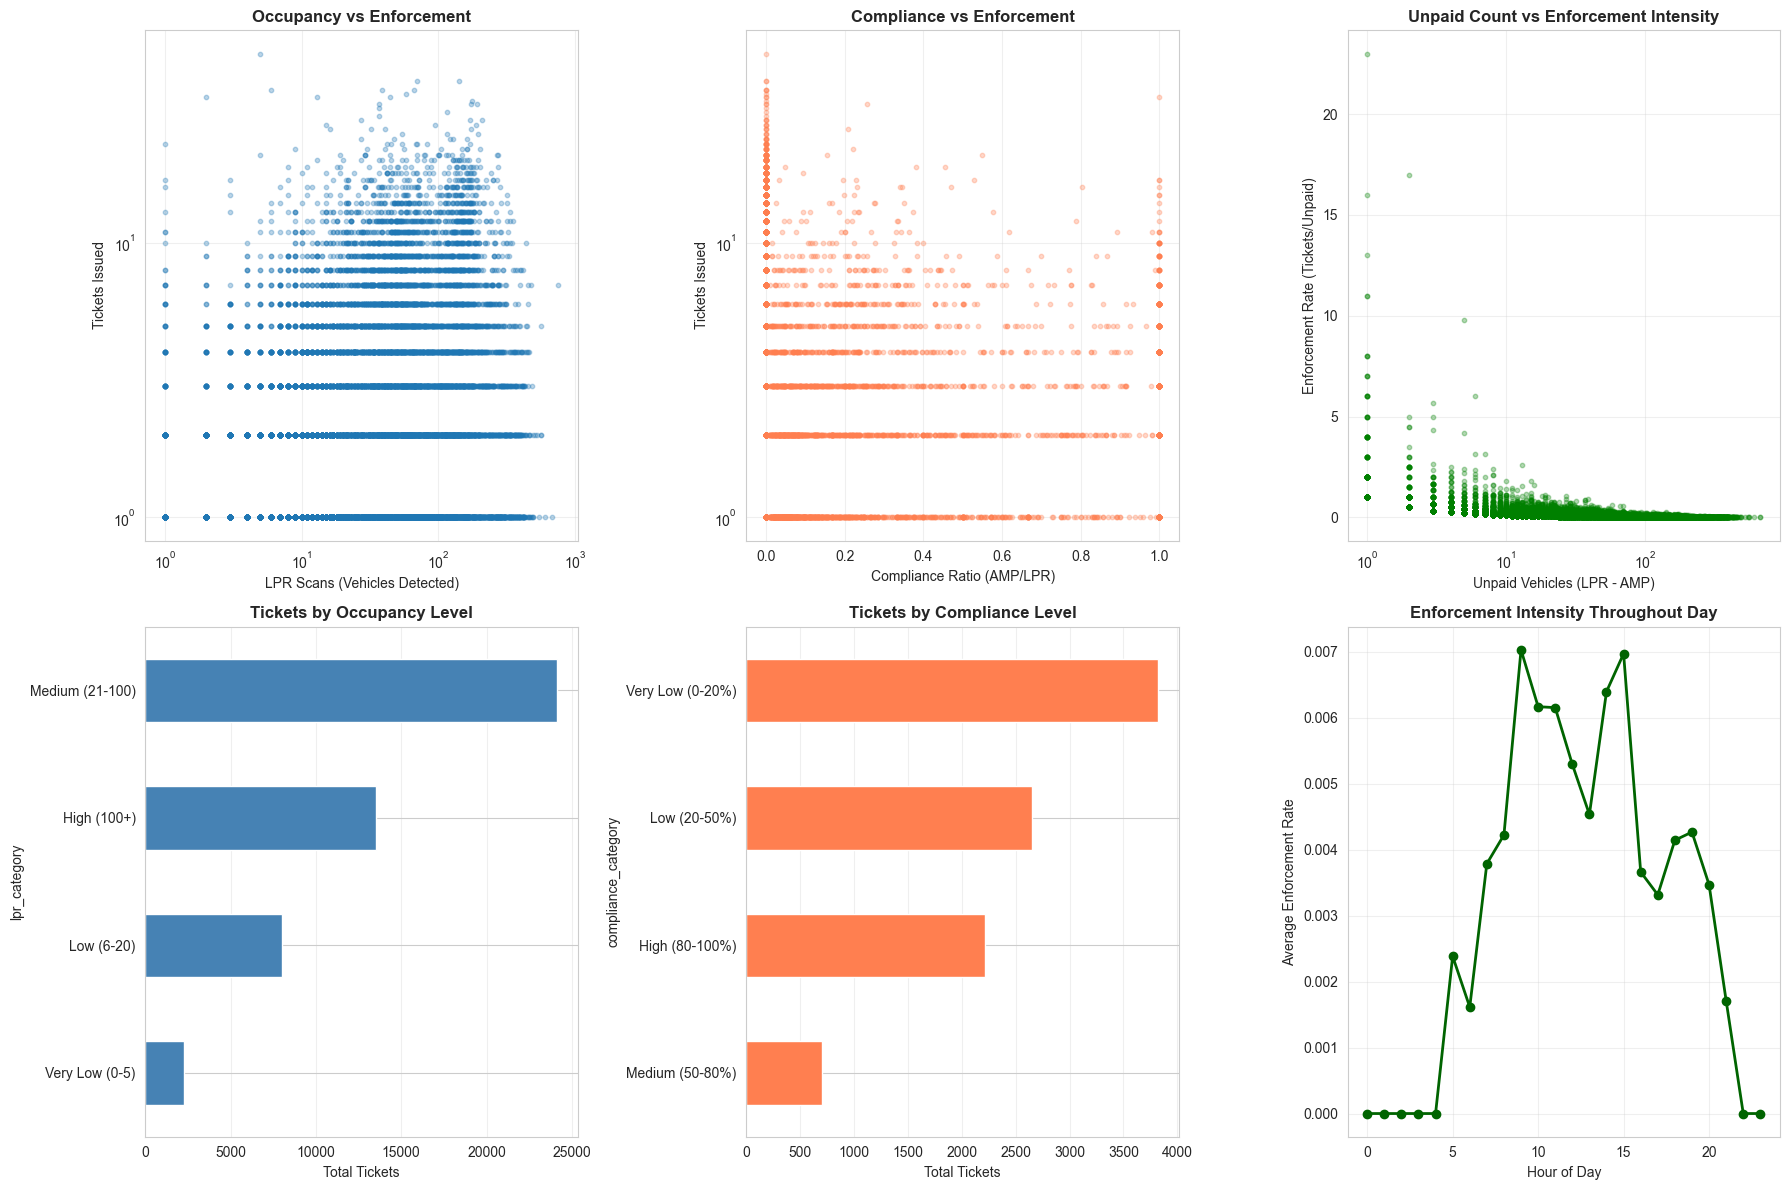

Visualization saved: enforcement_relationships.png


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
# 1. LPR scans vs Tickets (log scale for clarity)
active = enforcement[(enforcement['lpr_scans'] > 0) & (enforcement['tickets_issued'] > 0)]
axes[0,0].scatter(active['lpr_scans'], active['tickets_issued'], alpha=0.3, s=10)
axes[0,0].set_xlabel('LPR Scans (Vehicles Detected)')
axes[0,0].set_ylabel('Tickets Issued')
axes[0,0].set_title('Occupancy vs Enforcement', fontweight='bold')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].grid(alpha=0.3)
# 2. Compliance ratio vs Tickets
valid = enforcement[(enforcement['compliance_ratio'].notna()) & (enforcement['tickets_issued'] > 0)]
axes[0,1].scatter(valid['compliance_ratio'], valid['tickets_issued'], alpha=0.3, s=10, c='coral')
axes[0,1].set_xlabel('Compliance Ratio (AMP/LPR)')
axes[0,1].set_ylabel('Tickets Issued')
axes[0,1].set_title('Compliance vs Enforcement', fontweight='bold')
axes[0,1].set_yscale('log')
axes[0,1].grid(alpha=0.3)
# 3. Unpaid vehicles vs Enforcement rate
unpaid_active = enforcement[(enforcement['unpaid_estimate'] > 0) & (enforcement['enforcement_rate'] > 0)]
axes[0,2].scatter(unpaid_active['unpaid_estimate'], unpaid_active['enforcement_rate'], alpha=0.3, s=10, c='green')
axes[0,2].set_xlabel('Unpaid Vehicles (LPR - AMP)')
axes[0,2].set_ylabel('Enforcement Rate (Tickets/Unpaid)')
axes[0,2].set_title('Unpaid Count vs Enforcement Intensity', fontweight='bold')
axes[0,2].set_xscale('log')
axes[0,2].grid(alpha=0.3)
# 4. Tickets by occupancy category
occupancy_totals = enforcement.groupby('lpr_category')['tickets_issued'].sum().sort_values()
occupancy_totals.plot(kind='barh', ax=axes[1,0], color='steelblue')
axes[1,0].set_xlabel('Total Tickets')
axes[1,0].set_title('Tickets by Occupancy Level', fontweight='bold')
axes[1,0].grid(axis='x', alpha=0.3)
# 5. Tickets by compliance category
compliance_totals = enforcement.groupby('compliance_category')['tickets_issued'].sum().sort_values()
compliance_totals.plot(kind='barh', ax=axes[1,1], color='coral')
axes[1,1].set_xlabel('Total Tickets')
axes[1,1].set_title('Tickets by Compliance Level', fontweight='bold')
axes[1,1].grid(axis='x', alpha=0.3)
# 6. Average enforcement rate by hour
hourly_enforcement = enforcement.groupby('hour')['enforcement_rate'].mean()
hourly_enforcement.plot(kind='line', ax=axes[1,2], marker='o', color='darkgreen', linewidth=2)
axes[1,2].set_xlabel('Hour of Day')
axes[1,2].set_ylabel('Average Enforcement Rate')
axes[1,2].set_title('Enforcement Intensity Throughout Day', fontweight='bold')
axes[1,2].grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../../data/processed/enforcement_relationships.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualization saved: enforcement_relationships.png")

## 6. Feature Engineering for Prediction Models
Create useful features based on patterns discovered.

In [ ]:
# Create engineered features
enforcement['occupancy_level'] = pd.cut(
    enforcement['lpr_scans'],
    bins=[0, 5, 20, 100, float('inf')],
    labels=['very_low', 'low', 'medium', 'high']
)
enforcement['compliance_level'] = pd.cut(
    enforcement['compliance_ratio'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['low_compliance', 'medium_compliance', 'high_compliance']
)
# Vulnerability score: (Unpaid vehicles) * (Zone enforcement history)
# REMEMBER: Only unpaid vehicles can get tickets! AMP pass holders are immune.
zone_avg_enforcement = enforcement.groupby('Zone')['enforcement_rate'].mean()
enforcement['zone_avg_enforcement'] = enforcement['Zone'].map(zone_avg_enforcement)
enforcement['vulnerability_score'] = (
    enforcement['unpaid_estimate'] * enforcement['zone_avg_enforcement']
).fillna(0)
# High-risk indicator (high unpaid count + high enforcement zone)
enforcement['high_risk'] = (
    (enforcement['unpaid_estimate'] > enforcement['unpaid_estimate'].quantile(0.75)) &
    (enforcement['zone_avg_enforcement'] > enforcement['zone_avg_enforcement'].quantile(0.5))
).astype(int)
# Weather features (if available)
if 'temp_mean_f' in enforcement.columns:
    enforcement['is_bad_weather'] = (
        (enforcement['temp_mean_f'] < 35) |  # Freezing
        (enforcement['precipitation_inches'] > 0.1)  # Significant rain/snow
    ).astype(int)
elif 'temperature' in enforcement.columns:
    enforcement['is_bad_weather'] = (
        (enforcement['temperature'] < 35) |  # Freezing
        (enforcement['precipitation'] > 0.1)  # Significant rain/snow
    ).astype(int)
else:
    enforcement['is_bad_weather'] = 0
# Ensure year and time_of_day_code are in feature list
print("="*80)
print("ENGINEERED FEATURES FOR MODEL TRAINING")
print("="*80)
feature_columns = [
    'lpr_scans', 'amp_sessions', 'unpaid_estimate',
    'compliance_ratio', 'hour', 'day_of_week', 'month', 'year', 'is_weekend',
    'is_game_day', 'is_finals_week', 'is_any_break',
    'zone_avg_enforcement', 'vulnerability_score', 'high_risk',
    'time_of_day_code'
]
# Add weather features if available
if 'temp_mean_f' in enforcement.columns:
    feature_columns.extend(['temp_mean_f', 'precipitation_inches', 'is_rainy', 'is_snowy', 'is_cold', 'is_hot', 'is_windy'])
elif 'temperature' in enforcement.columns:
    feature_columns.extend(['temperature', 'precipitation', 'is_bad_weather'])
print(f"\nFeatures created: {len(feature_columns)}")
print(f"Key features:")
for feat in feature_columns:
    if feat in enforcement.columns:
        print(f"   {feat}")
    else:
        print(f"   {feat} (missing)")
print(f"\n KEY INSIGHT:")
print(f"   Total vehicles (LPR): {enforcement['lpr_scans'].sum():,.0f}")
print(f"   Paid parking (AMP): {enforcement['amp_sessions'].sum():,.0f}  Protected from tickets")
print(f"   Unpaid (potential violators): {enforcement['unpaid_estimate'].sum():,.0f} ")
print(f"   Tickets issued: {enforcement['tickets_issued'].sum():,.0f}")
print(f"   Overall catch rate: {enforcement['tickets_issued'].sum() / enforcement['unpaid_estimate'].sum() * 100:.1f}%")
print(f"\nHigh-risk hours: {enforcement['high_risk'].sum():,} ({enforcement['high_risk'].sum()/len(enforcement)*100:.1f}%)")
print(f"Tickets in high-risk hours: {enforcement[enforcement['high_risk']==1]['tickets_issued'].sum():,}")
print(f"Tickets in low-risk hours: {enforcement[enforcement['high_risk']==0]['tickets_issued'].sum():,}")
if 'is_bad_weather' in enforcement.columns:
    bad_weather_hours = enforcement[enforcement['is_bad_weather']==1]
    good_weather_hours = enforcement[enforcement['is_bad_weather']==0]
    print(f"\nBad weather hours: {len(bad_weather_hours):,}")
    print(f"  Avg enforcement rate: {bad_weather_hours['enforcement_rate'].mean():.3f}")
    print(f"Good weather hours: {len(good_weather_hours):,}")
    print(f"  Avg enforcement rate: {good_weather_hours['enforcement_rate'].mean():.3f}")
# Show temporal trends by year
print(f"\nEnforcement trends by year:")
year_stats = enforcement.groupby('year').agg({
    'tickets_issued': 'sum',
    'enforcement_rate': 'mean',
    'unpaid_estimate': 'sum'
}).round(3)
print(year_stats)

ENGINEERED FEATURES FOR MODEL TRAINING

Features created: 16
Key features:
   lpr_scans
   amp_sessions
   unpaid_estimate
   compliance_ratio
   hour
   day_of_week
   month
   year
   is_weekend
   is_game_day
   is_finals_week
   is_any_break
   zone_avg_enforcement
   vulnerability_score
   high_risk
   time_of_day_code

 KEY INSIGHT:
   Total vehicles (LPR): 2,937,320
   Paid parking (AMP): 1,154,032  Protected from tickets
   Unpaid (potential violators): 2,687,580 ⚠️
   Tickets issued: 53,493
   Overall catch rate: 2.0%

High-risk hours: 52,597 (7.2%)
Tickets in high-risk hours: 43,425
Tickets in low-risk hours: 10,068

Bad weather hours: 0
  Avg enforcement rate: nan
Good weather hours: 730,800
  Avg enforcement rate: 0.003

Enforcement trends by year:
      tickets_issued  enforcement_rate  unpaid_estimate
year                                                   
2022            7675             0.003           161840
2023           15733             0.002           573769
2024 

## 7. Save Enhanced Enforcement Data

In [ ]:
# Save with new features
output_file = '../../data/processed/enforcement_with_features.csv'
enforcement.to_csv(output_file, index=False)
print(f"\nSaved enhanced enforcement data: {output_file}")
print(f"Records: {len(enforcement):,}")
print(f"Columns: {len(enforcement.columns)}")


Saved enhanced enforcement data: ../../data/processed/enforcement_with_features.csv
Records: 730,800
Columns: 48


## Key Findings Summary

In [ ]:
active_hours = enforcement[enforcement['lpr_scans'] > 0]
if len(active_hours) > 0:
    lpr_corr = active_hours['lpr_scans'].corr(active_hours['tickets_issued'])
    unpaid_corr = active_hours['unpaid_estimate'].corr(active_hours['tickets_issued'])
    print(f"\n2. CORRELATION ANALYSIS:")
    print(f"   - LPR scans -> Tickets: {lpr_corr:.3f}")
    print(f"   - Unpaid vehicles -> Tickets: {unpaid_corr:.3f}")
    if unpaid_corr > lpr_corr:
        print("    Unpaid estimate is stronger predictor than total occupancy")
        print("   -> Supports assumption: most tickets are for non-payment")
        print("   -> But correlation isn't perfect due to other violation types")
    else:
        print("    Total occupancy correlates more than unpaid count")
        print("   -> May indicate: enforcement scales with overall traffic")
        print("   -> Or: significant portion of tickets are non-payment violations")
print("\n3. APPROXIMATE ENFORCEMENT CATCH RATE:")
print("   (With caveat: includes non-payment violations as noise)")
unpaid_total = enforcement['unpaid_estimate'].sum()
tickets_total = enforcement['tickets_issued'].sum()
if unpaid_total > 0:
    catch_rate = tickets_total / unpaid_total * 100
    print(f"   Apparent rate: {catch_rate:.2f}% of unpaid vehicles get tickets")
    print(f"   That's ~1 ticket per {unpaid_total/tickets_total:.0f} unpaid vehicles")
    print(f"   NOTE: Actual payment violation rate is lower (some tickets are for other reasons)")
    # By zone
    zone_catch = enforcement.groupby('Zone').agg({
        'unpaid_estimate': 'sum',
        'tickets_issued': 'sum'
    })
    zone_catch['catch_rate'] = zone_catch['tickets_issued'] / zone_catch['unpaid_estimate'] * 100
    zone_catch = zone_catch[zone_catch['unpaid_estimate'] > 100].sort_values('catch_rate', ascending=False)
    print(f"\n   Zones with highest apparent enforcement:")
    for zone in zone_catch.head(5).index:
        rate = zone_catch.loc[zone, 'catch_rate']
        print(f"     {zone}: {rate:.2f}%")
print("\n4. MODEL READY:")


2. CORRELATION ANALYSIS:
   - LPR scans → Tickets: 0.196
   - Unpaid vehicles → Tickets: 0.195
    Total occupancy correlates more than unpaid count
   → May indicate: enforcement scales with overall traffic
   → Or: significant portion of tickets are non-payment violations

3. APPROXIMATE ENFORCEMENT CATCH RATE:
   (With caveat: includes non-payment violations as noise)
   Apparent rate: 1.99% of unpaid vehicles get tickets
   That's ~1 ticket per 50 unpaid vehicles
   NOTE: Actual payment violation rate is lower (some tickets are for other reasons)

   Zones with highest apparent enforcement:
     Paid: 6.53%
     Green 5: 4.95%
     Orange 4: 4.94%
     Authorized Vehicles Only: 3.16%
     Green 4: 3.15%

4. MODEL READY:


## 9. Visualize Weather Impact

In [ ]:
# Check if enforcement data already has weather
if 'temperature' in enforcement.columns:
    print("Weather data already merged!")
else:
    print("Loading HOURLY weather data...")
    weather = pd.read_csv('../../data/weather_pullman_hourly_2020_2025.csv', parse_dates=['datetime'])
    print(f"Weather columns: {list(weather.columns)}")
    print(f"Weather data: {len(weather):,} hourly records")
    # Rename columns to match our expected names
    weather = weather.rename(columns={
        'temperature_f': 'temperature',
        'precipitation_inches': 'precipitation',
        'weather_category': 'conditions'
    })
    # HOURLY merge: Match by date AND hour!
    # Create merge keys
    enforcement['merge_key'] = enforcement['date'].astype(str) + '_' + enforcement['hour'].astype(str)
    weather['date_only'] = pd.to_datetime(weather['datetime']).dt.date
    weather['merge_key'] = weather['date_only'].astype(str) + '_' + weather['hour'].astype(str)
    print(f"\nMerging by date + hour...")
    print(f"  Enforcement records: {len(enforcement):,}")
    print(f"  Weather records: {len(weather):,}")
    enforcement = enforcement.merge(
        weather[['merge_key', 'temperature', 'precipitation', 'conditions', 'snowfall_inches', 'wind_mph']],
        on='merge_key',
        how='left'
    )
    enforcement.drop('merge_key', axis=1, inplace=True)
    matched = enforcement['temperature'].notna().sum()
    print(f" HOURLY weather data merged! {matched:,} / {len(enforcement):,} records matched ({matched/len(enforcement)*100:.1f}%)")
# Weather impact analysis
print("\n" + "="*80)
print("WEATHER IMPACT ON ENFORCEMENT")
print("="*80)
# Temperature categories
enforcement['temp_category'] = pd.cut(
    enforcement['temperature'],
    bins=[-float('inf'), 32, 50, 70, float('inf')],
    labels=['Freezing (<32°F)', 'Cold (32-50°F)', 'Mild (50-70°F)', 'Warm (70+°F)']
)
# Precipitation categories
enforcement['precip_category'] = pd.cut(
    enforcement['precipitation'],
    bins=[-0.01, 0, 0.1, 0.5, float('inf')],
    labels=['None', 'Light (<0.1")', 'Moderate (0.1-0.5")', 'Heavy (>0.5")']
)
# Analyze by temperature
temp_analysis = enforcement.groupby('temp_category').agg({
    'tickets_issued': ['sum', 'mean'],
    'enforcement_rate': 'mean',
    'lpr_scans': 'mean',
    'unpaid_estimate': 'mean'
}).round(3)
print("\nENFORCEMENT BY TEMPERATURE:")
print(temp_analysis)
# Analyze by precipitation
precip_analysis = enforcement.groupby('precip_category').agg({
    'tickets_issued': ['sum', 'mean'],
    'enforcement_rate': 'mean',
    'lpr_scans': 'mean',
    'unpaid_estimate': 'mean'
}).round(3)
print("\nENFORCEMENT BY PRECIPITATION:")
print(precip_analysis)
# Statistical test
weather_data = enforcement[enforcement['temperature'].notna()]
if len(weather_data) > 0:
    temp_corr = weather_data['temperature'].corr(weather_data['enforcement_rate'])
    precip_corr = weather_data['precipitation'].corr(weather_data['enforcement_rate'])
    print(f"\nCORRELATIONS:")
    print(f"  Temperature vs Enforcement Rate: {temp_corr:.3f}")
    print(f"  Precipitation vs Enforcement Rate: {precip_corr:.3f}")
    if temp_corr > 0.05:
        print("   Warmer weather -> More enforcement")
    elif temp_corr < -0.05:
        print("   Colder weather -> Less enforcement")
    else:
        print("  ~ Temperature has minimal effect on enforcement")
    if precip_corr < -0.05:
        print("   Rain/snow -> Less enforcement (officers stay in vehicles/office)")
    elif precip_corr > 0.05:
        print("   Rain/snow -> More enforcement (unexpected!)")
    else:
        print("  ~ Precipitation has minimal effect on enforcement")

Loading HOURLY weather data...
Weather columns: ['datetime', 'temperature_f', 'precipitation_inches', 'snowfall_inches', 'snow_depth_inches', 'wind_mph', 'weather_code', 'date', 'hour', 'year', 'weather_category', 'is_rainy', 'is_snowy', 'is_cold', 'is_hot', 'is_windy', 'is_severe']
Weather data: 51,144 hourly records

Merging by date + hour...
  Enforcement records: 730,800
  Weather records: 51,144
 HOURLY weather data merged! 730,800 / 730,800 records matched (100.0%)

WEATHER IMPACT ON ENFORCEMENT

ENFORCEMENT BY TEMPERATURE:
                 tickets_issued        enforcement_rate lpr_scans  \
                            sum   mean             mean      mean   
temp_category                                                       
Freezing (<32°F)           4479  0.048            0.002     1.886   
Cold (32-50°F)            18262  0.070            0.003     3.379   
Mild (50-70°F)            17079  0.073            0.003     4.245   
Warm (70+°F)              13673  0.096            

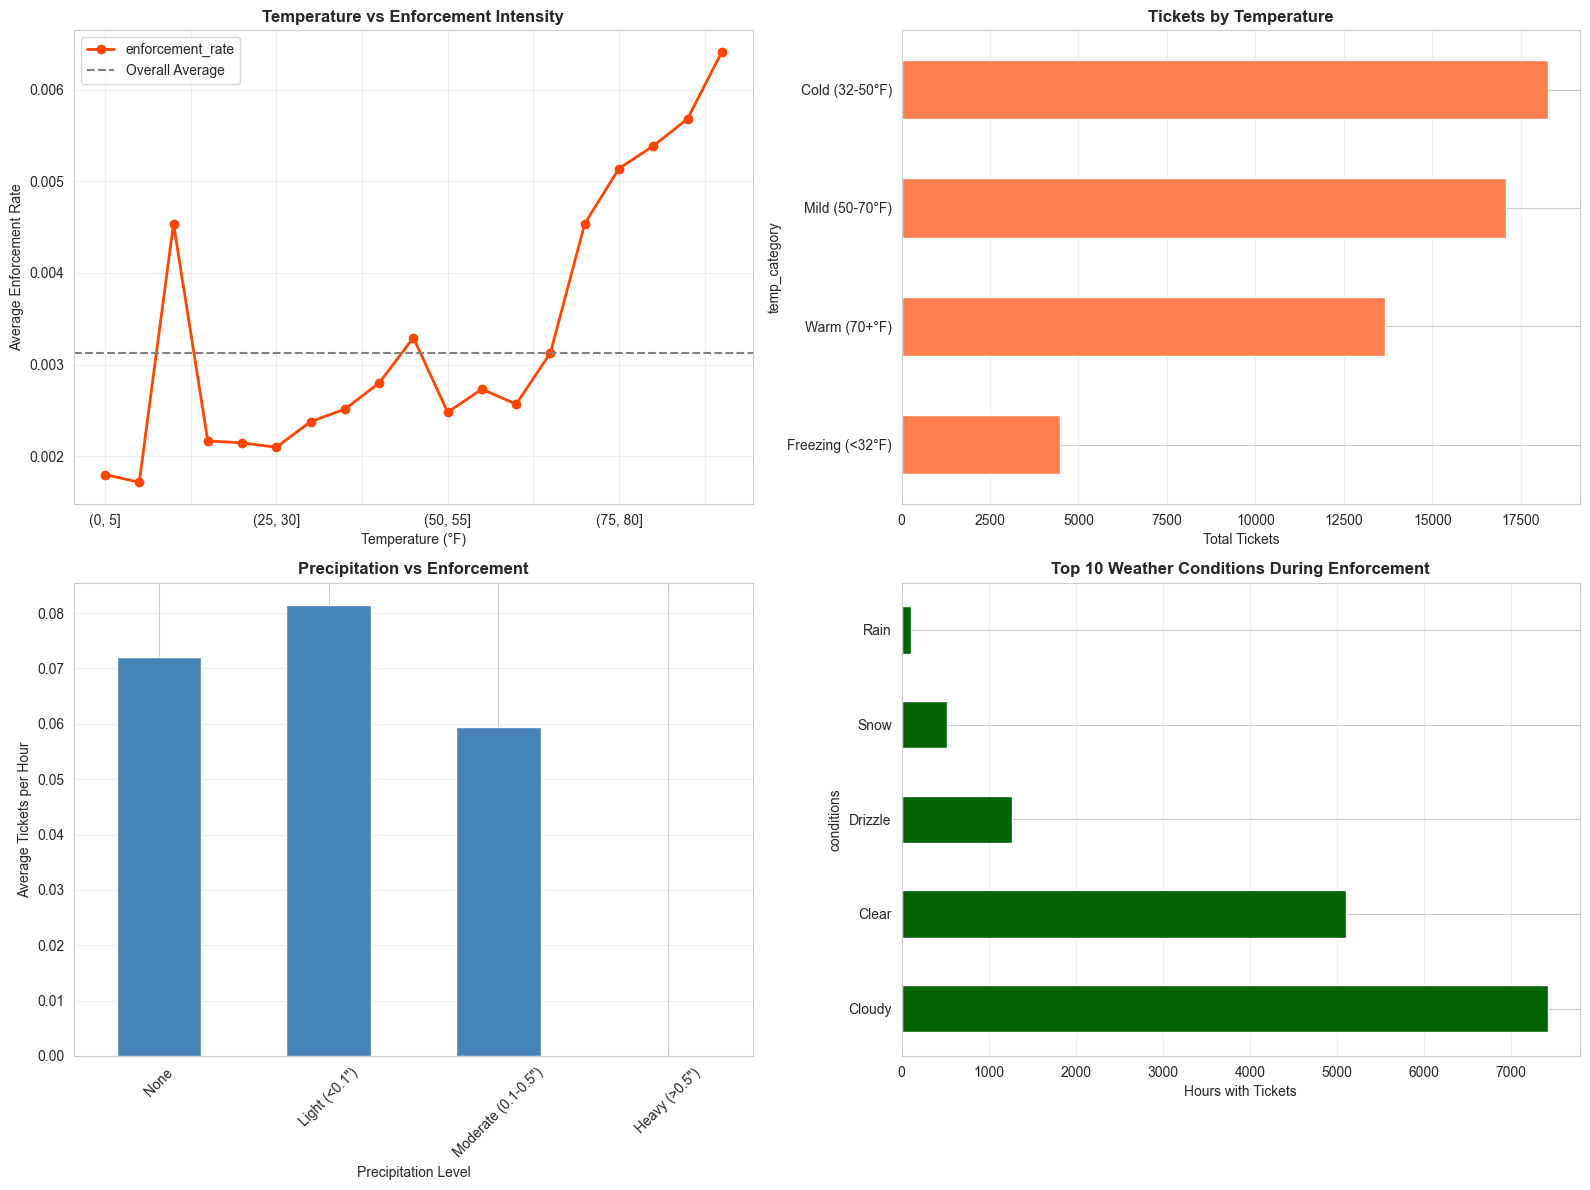

Weather impact visualization saved: weather_enforcement_impact.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
weather_data = enforcement[enforcement['temperature'].notna()]
if len(weather_data) > 0:
    # 1. Temperature vs Enforcement Rate
    temp_bins = range(0, 100, 5)
    temp_grouped = weather_data.groupby(pd.cut(weather_data['temperature'], bins=temp_bins))['enforcement_rate'].mean()
    temp_grouped.plot(kind='line', ax=axes[0,0], marker='o', color='orangered', linewidth=2)
    axes[0,0].set_xlabel('Temperature (°F)')
    axes[0,0].set_ylabel('Average Enforcement Rate')
    axes[0,0].set_title('Temperature vs Enforcement Intensity', fontweight='bold')
    axes[0,0].grid(alpha=0.3)
    axes[0,0].axhline(weather_data['enforcement_rate'].mean(), color='gray', linestyle='--', label='Overall Average')
    axes[0,0].legend()
    # 2. Tickets by temperature category
    temp_tickets = enforcement.groupby('temp_category')['tickets_issued'].sum().sort_values()
    temp_tickets.plot(kind='barh', ax=axes[0,1], color='coral')
    axes[0,1].set_xlabel('Total Tickets')
    axes[0,1].set_title('Tickets by Temperature', fontweight='bold')
    axes[0,1].grid(axis='x', alpha=0.3)
    # 3. Precipitation vs Enforcement Rate
    precip_tickets = enforcement.groupby('precip_category')['tickets_issued'].mean()
    precip_tickets.plot(kind='bar', ax=axes[1,0], color='steelblue')
    axes[1,0].set_xlabel('Precipitation Level')
    axes[1,0].set_ylabel('Average Tickets per Hour')
    axes[1,0].set_title('Precipitation vs Enforcement', fontweight='bold')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)
    # 4. Weather conditions distribution
    if 'conditions' in enforcement.columns:
        condition_counts = enforcement[enforcement['tickets_issued'] > 0]['conditions'].value_counts().head(10)
        condition_counts.plot(kind='barh', ax=axes[1,1], color='darkgreen')
        axes[1,1].set_xlabel('Hours with Tickets')
        axes[1,1].set_title('Top 10 Weather Conditions During Enforcement', fontweight='bold')
        axes[1,1].grid(axis='x', alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Weather conditions\ndata not available', 
                      ha='center', va='center', fontsize=14)
        axes[1,1].axis('off')
    plt.tight_layout()
    plt.savefig('../../data/processed/weather_enforcement_impact.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Weather impact visualization saved: weather_enforcement_impact.png")
else:
    print("No weather data available for visualization")

## 11. Weather Impact on Foot Patrols
Foot patrols should be much more affected by bad weather than vehicle patrols.

## 11. TIME-BASED PATROL CLASSIFICATION (Using Minute-Level Timestamps)
Use temporal proximity to classify patrol types:
- **Fixed Camera**: LPR scans with NO tickets within grace period (5-15 min)
- **Vehicle Patrol**: LPR scan followed by ticket within grace period
- **Foot Patrol**: Ticket with NO LPR scans nearby in time

In [ ]:
print("="*80)
print("TIME-BASED PATROL CLASSIFICATION")
print("="*80)
# Load raw data with minute-level timestamps
print("\nLoading raw data with timestamps...")
tickets_raw = pd.read_csv('../../data/processed/tickets_enriched.csv', parse_dates=['Issue_DateTime'])
lpr_raw = pd.read_csv('../../data/processed/lpr_enriched.csv', parse_dates=['Date_Time'])
print(f"Tickets: {len(tickets_raw):,} records")
print(f"LPR scans: {len(lpr_raw):,} records")
# Grace period for linking LPR to tickets (in minutes)
GRACE_PERIOD_MIN = 5  # 10 minutes - enforcement typically acts quickly
print(f"\nGrace period: {GRACE_PERIOD_MIN} minutes")
print(f"Logic:")
print(f"  - LPR scan + ticket within {GRACE_PERIOD_MIN} min -> Vehicle patrol")
print(f"  - Ticket + NO LPR within {GRACE_PERIOD_MIN} min -> Foot patrol")
print(f"  - LPR scans + NO tickets within {GRACE_PERIOD_MIN} min -> Fixed camera")
# Filter to overlap period only (where both datasets exist)
ticket_min = tickets_raw['Issue_DateTime'].min()
ticket_max = tickets_raw['Issue_DateTime'].max()
lpr_min = lpr_raw['Date_Time'].min()
lpr_max = lpr_raw['Date_Time'].max()
overlap_start = max(ticket_min, lpr_min)
overlap_end = min(ticket_max, lpr_max)
print(f"\nFiltering to overlap period: {overlap_start} to {overlap_end}")
tickets_raw = tickets_raw[(tickets_raw['Issue_DateTime'] >= overlap_start) & (tickets_raw['Issue_DateTime'] <= overlap_end)]
lpr_raw = lpr_raw[(lpr_raw['Date_Time'] >= overlap_start) & (lpr_raw['Date_Time'] <= overlap_end)]
print(f"Tickets in overlap: {len(tickets_raw):,}")
print(f"LPR scans in overlap: {len(lpr_raw):,}")
# Match by ZONE_NAME not lot number (lot numbers don't align between datasets)
# For each ticket, check if there was an LPR scan in the SAME ZONE within grace period BEFORE the ticket
print(f"\nAnalyzing {len(tickets_raw):,} tickets by ZONE...")
print("This may take a few minutes...")
# Sample first 10,000 tickets for testing (remove this for full analysis)
tickets_sample = tickets_raw.head(10000).copy()
tickets_sample['patrol_type_detailed'] = 'UNKNOWN'
tickets_sample['lpr_before_ticket'] = 0
tickets_sample['minutes_since_lpr'] = None
for idx, ticket in tickets_sample.iterrows():
    if idx % 1000 == 0:
        print(f"  Processed {idx:,} / {len(tickets_sample)*10:,} tickets...") 
    zone = ticket['Zone_Name']
    ticket_time = ticket['Issue_DateTime']   
    # Skip if no zone mapping
    if pd.isna(zone):
        continue
    # Find LPR scans in same ZONE within grace period BEFORE ticket
    lpr_in_zone = lpr_raw[
        (lpr_raw['Zone_Name'] == zone) &
        (lpr_raw['Date_Time'] <= ticket_time) &
        (lpr_raw['Date_Time'] >= ticket_time - pd.Timedelta(minutes=GRACE_PERIOD_MIN))
    ]
    if len(lpr_in_zone) > 0:
        # Vehicle patrol: LPR scan found before ticket
        tickets_sample.at[idx, 'patrol_type_detailed'] = 'VEHICLE_PATROL'
        tickets_sample.at[idx, 'lpr_before_ticket'] = 1
        # Calculate time since most recent LPR scan
        most_recent_lpr = lpr_in_zone['Date_Time'].max()
        minutes_diff = (ticket_time - most_recent_lpr).total_seconds() / 60
        tickets_sample.at[idx, 'minutes_since_lpr'] = minutes_diff
    else:
        # Foot patrol: No LPR scan found before ticket
        tickets_sample.at[idx, 'patrol_type_detailed'] = 'FOOT_PATROL'
        tickets_sample.at[idx, 'lpr_before_ticket'] = 0
print("\nClassification complete!")
# Summary statistics
vehicle_patrol_count = (tickets_sample['patrol_type_detailed'] == 'VEHICLE_PATROL').sum()
foot_patrol_count = (tickets_sample['patrol_type_detailed'] == 'FOOT_PATROL').sum()
total = len(tickets_sample)
print(f"\n{'='*80}")
print(f"PATROL TYPE CLASSIFICATION RESULTS (Sample: {total:,} tickets)")
print(f"{'='*80}")
print(f"Vehicle patrol: {vehicle_patrol_count:,} ({vehicle_patrol_count/total*100:.1f}%)")
print(f"  - Had LPR scan in same lot within {GRACE_PERIOD_MIN} min before ticket")
print(f"Foot patrol: {foot_patrol_count:,} ({foot_patrol_count/total*100:.1f}%)")
print(f"  - NO LPR scan in same lot within {GRACE_PERIOD_MIN} min before ticket")
# Time distribution for vehicle patrol tickets
vehicle_tickets = tickets_sample[tickets_sample['patrol_type_detailed'] == 'VEHICLE_PATROL']
if len(vehicle_tickets) > 0:
    print(f"\nVehicle patrol timing:")
    print(f"  Average time from LPR to ticket: {vehicle_tickets['minutes_since_lpr'].mean():.1f} minutes")
    print(f"  Median: {vehicle_tickets['minutes_since_lpr'].median():.1f} minutes")
    print(f"  Min: {vehicle_tickets['minutes_since_lpr'].min():.1f} minutes")
    print(f"  Max: {vehicle_tickets['minutes_since_lpr'].max():.1f} minutes")

TIME-BASED PATROL CLASSIFICATION

Loading raw data with timestamps...
Tickets: 192,709 records
LPR scans: 1,780,391 records

Grace period: 5 minutes
Logic:
  - LPR scan + ticket within 5 min → Vehicle patrol
  - Ticket + NO LPR within 5 min → Foot patrol
  - LPR scans + NO tickets within 5 min → Fixed camera

Filtering to overlap period: 2022-07-01 05:24:26 to 2025-06-30 21:58:49
Tickets in overlap: 96,452
LPR scans in overlap: 1,780,391

Analyzing 96,452 tickets by ZONE...
This may take a few minutes...
  Processed 83,000 / 100,000 tickets...
  Processed 84,000 / 100,000 tickets...
  Processed 85,000 / 100,000 tickets...
  Processed 86,000 / 100,000 tickets...
  Processed 87,000 / 100,000 tickets...
  Processed 88,000 / 100,000 tickets...
  Processed 89,000 / 100,000 tickets...
  Processed 90,000 / 100,000 tickets...
  Processed 91,000 / 100,000 tickets...
  Processed 92,000 / 100,000 tickets...

Classification complete!

PATROL TYPE CLASSIFICATION RESULTS (Sample: 10,000 tickets)
Veh

In [ ]:
print("="*80)
print("PATROL TYPE CLASSIFICATION - FIXED CAMERA DETECTION")
print("="*80)
# Step 1: Identify zones with FIXED CAMERAS
# Fixed cameras have consistent LPR activity (high % of hours with scans)
zone_lpr_stats = enforcement.groupby('Zone').agg({
    'lpr_scans': 'count',
    'tickets_issued': 'sum'
})
zone_lpr_stats.columns = ['total_hours', 'total_tickets']
# Count hours with LPR activity per zone
zone_lpr_active = enforcement[enforcement['lpr_scans'] > 0].groupby('Zone').size()
zone_lpr_stats['hours_with_lpr'] = zone_lpr_active
zone_lpr_stats['pct_hours_with_lpr'] = (zone_lpr_stats['hours_with_lpr'] / zone_lpr_stats['total_hours'] * 100).fillna(0)
# FIXED CAMERA THRESHOLD: >50% of hours have LPR activity
# This indicates entrance/exit cameras, not mobile patrols
FIXED_CAMERA_THRESHOLD = 50.0
fixed_camera_zones = zone_lpr_stats[zone_lpr_stats['pct_hours_with_lpr'] > FIXED_CAMERA_THRESHOLD].index.tolist()
print(f"\n FIXED CAMERA ZONES IDENTIFIED:")
print(f"   Threshold: >{FIXED_CAMERA_THRESHOLD}% of hours with LPR activity")
print(f"   Zones with fixed cameras: {len(fixed_camera_zones)}")
for zone in fixed_camera_zones:
    pct = zone_lpr_stats.loc[zone, 'pct_hours_with_lpr']
    tickets = zone_lpr_stats.loc[zone, 'total_tickets']
    print(f"     - {zone}: {pct:.1f}% hours with LPR, {tickets:,} tickets")
print(f"\n  CLASSIFICATION LIMITATION:")
print(f"   For zones WITHOUT fixed cameras (lots 071, 150, 084, etc.):")
print(f"   - LPR scans could be from patrol vehicle passing through")
print(f"   - Tickets could be from foot patrol at a different time")
print(f"   - We CANNOT reliably link LPR scans to ticket enforcement")
print(f"   -> Patrol type classification is NOT RELIABLE for these zones")
# Step 2: Classification
# Fixed camera zones: ALL tickets are foot patrol (LPR is just entrance camera)
# Other zones: UNKNOWN (cannot determine patrol type reliably)
enforcement['has_fixed_camera'] = enforcement['Zone'].isin(fixed_camera_zones).astype(int)
# For fixed camera zones: tickets are foot patrol
# For other zones: mark as UNKNOWN
enforcement['patrol_type'] = 'UNKNOWN'
enforcement.loc[
    (enforcement['tickets_issued'] > 0) & 
    (enforcement['has_fixed_camera'] == 1),
    'patrol_type'
] = 'FOOT_PATROL'
enforcement['foot_patrol_tickets'] = np.where(
    enforcement['patrol_type'] == 'FOOT_PATROL',
    enforcement['tickets_issued'],
    0
)
enforcement['unknown_patrol_tickets'] = np.where(
    (enforcement['tickets_issued'] > 0) & (enforcement['patrol_type'] == 'UNKNOWN'),
    enforcement['tickets_issued'],
    0
)
# Summary
foot_total = enforcement['foot_patrol_tickets'].sum()
unknown_total = enforcement['unknown_patrol_tickets'].sum()
total_tickets = enforcement['tickets_issued'].sum()

PATROL TYPE CLASSIFICATION - FIXED CAMERA DETECTION

 FIXED CAMERA ZONES IDENTIFIED:
   Threshold: >50.0% of hours with LPR activity
   Zones with fixed cameras: 1
     - Paid: 68.8% hours with LPR, 28,854 tickets

⚠️  CLASSIFICATION LIMITATION:
   For zones WITHOUT fixed cameras (lots 071, 150, 084, etc.):
   - LPR scans could be from patrol vehicle passing through
   - Tickets could be from foot patrol at a different time
   - We CANNOT reliably link LPR scans to ticket enforcement
   → Patrol type classification is NOT RELIABLE for these zones


## 10. Foot Patrol vs Vehicle Patrol Analysis
Separate enforcement by patrol type to better understand weather impact.

## 8. Weather Impact on Enforcement
Does bad weather reduce enforcement activity?

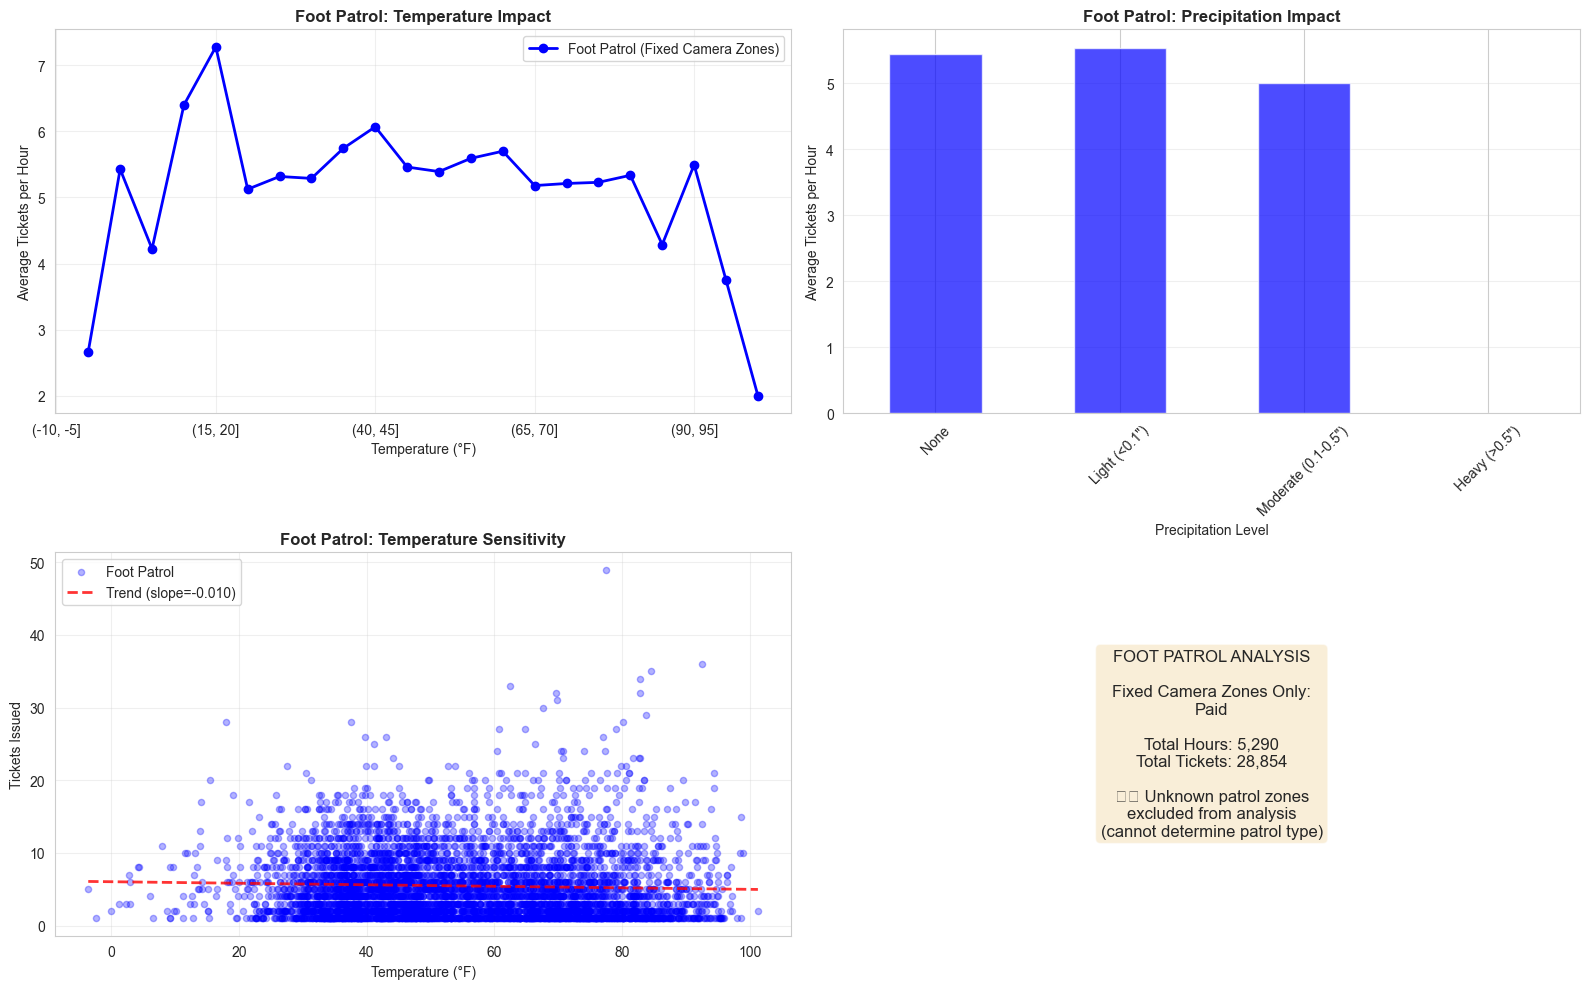

Foot patrol weather impact visualization saved!


In [ ]:
if 'temperature' in enforcement.columns:
    weather_data = enforcement[enforcement['temperature'].notna()]
    # Only analyze reliable foot patrol data (fixed camera zones)
    foot_patrol = weather_data[weather_data['patrol_type'] == 'FOOT_PATROL']    
    if len(foot_patrol) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))     
        # 1. Temperature bins for foot patrol
        temp_bins = range(int(weather_data['temperature'].min()), int(weather_data['temperature'].max())+5, 5)        
        # Foot patrol temperature - use ticket counts
        foot_temp_sum = foot_patrol.groupby(pd.cut(foot_patrol['temperature'], bins=temp_bins))['foot_patrol_tickets'].sum()
        foot_temp_hours = foot_patrol.groupby(pd.cut(foot_patrol['temperature'], bins=temp_bins)).size()
        foot_temp_avg = foot_temp_sum / foot_temp_hours
        foot_temp_avg.plot(kind='line', ax=axes[0,0], marker='o', color='blue', linewidth=2, label='Foot Patrol (Fixed Camera Zones)')        
        axes[0,0].set_xlabel('Temperature (°F)')
        axes[0,0].set_ylabel('Average Tickets per Hour')
        axes[0,0].set_title('Foot Patrol: Temperature Impact', fontweight='bold')
        axes[0,0].legend()
        axes[0,0].grid(alpha=0.3)        
        # 2. Precipitation comparison
        foot_precip_sum = foot_patrol.groupby('precip_category')['foot_patrol_tickets'].sum()
        foot_precip_hours = foot_patrol.groupby('precip_category').size()
        foot_precip_avg = foot_precip_sum / foot_precip_hours
        foot_precip_avg.plot(kind='bar', ax=axes[0,1], color='blue', alpha=0.7)
        axes[0,1].set_xlabel('Precipitation Level')
        axes[0,1].set_ylabel('Average Tickets per Hour')
        axes[0,1].set_title('Foot Patrol: Precipitation Impact', fontweight='bold')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].grid(axis='y', alpha=0.3)        
        # 3. Scatter: Temperature vs tickets for foot patrol
        axes[1,0].scatter(foot_patrol['temperature'], foot_patrol['foot_patrol_tickets'], 
                         alpha=0.3, s=20, c='blue', label='Foot Patrol')
        axes[1,0].set_xlabel('Temperature (°F)')
        axes[1,0].set_ylabel('Tickets Issued')
        axes[1,0].set_title('Foot Patrol: Temperature Sensitivity', fontweight='bold')
        # Add trend line
        if len(foot_patrol) > 10:
            z = np.polyfit(foot_patrol['temperature'], foot_patrol['foot_patrol_tickets'], 1)
            p = np.poly1d(z)
            axes[1,0].plot(sorted(foot_patrol['temperature']), p(sorted(foot_patrol['temperature'])), 
                          "r--", alpha=0.8, linewidth=2, label=f'Trend (slope={z[0]:.3f})')
        axes[1,0].legend()
        axes[1,0].grid(alpha=0.3)
        # 4. Info text about data limitation
        axes[1,1].text(0.5, 0.5, 
                      f'FOOT PATROL ANALYSIS\n\n'
                      f'Fixed Camera Zones Only:\n{", ".join(fixed_camera_zones)}\n\n'
                      f'Total Hours: {len(foot_patrol):,}\n'
                      f'Total Tickets: {foot_patrol["foot_patrol_tickets"].sum():,}\n\n'
                      f' Unknown patrol zones\n'
                      f'excluded from analysis\n'
                      f'(cannot determine patrol type)', 
                      ha='center', va='center', fontsize=12, 
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[1,1].axis('off')
        plt.tight_layout()
        plt.savefig('../../data/processed/foot_patrol_weather_impact.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Foot patrol weather impact visualization saved!")
    else:
        print("Not enough foot patrol data for visualization")
else:
    print("Weather data not available for visualization")


## 12. Visualize Patrol Type Weather Impact

In [ ]:
if 'temperature' in enforcement.columns:
    print("\n" + "="*80)
    print("WEATHER IMPACT ON FOOT PATROL (FIXED CAMERA ZONES ONLY)")
    print("="*80)
    weather_data = enforcement[enforcement['temperature'].notna()]
    # Only analyze RELIABLE foot patrol data (fixed camera zones)
    foot_patrol = weather_data[weather_data['patrol_type'] == 'FOOT_PATROL']
    print(f"\nAnalyzing {len(foot_patrol):,} hours from fixed camera zones")
    print(f"Total tickets in analysis: {foot_patrol['foot_patrol_tickets'].sum():,}")
    print(f"Fixed camera zones: {', '.join(fixed_camera_zones)}")
    if len(foot_patrol) > 0:
        print("\n" + "-"*80)
        print("FOOT PATROL - Temperature Analysis")
        print("-"*80)
        foot_temp = foot_patrol.groupby('temp_category').agg({
            'foot_patrol_tickets': ['sum', 'mean'],
            'tickets_issued': 'sum'
        }).round(3)
        foot_temp.columns = ['Total_Tickets', 'Avg_per_Hour', 'Hours_Active']
        print(foot_temp)
        # Correlation
        temp_corr_foot = foot_patrol['temperature'].corr(foot_patrol['foot_patrol_tickets'])
        print(f"\nTemperature -> Foot patrol tickets correlation: {temp_corr_foot:.3f}")
        print("\n" + "-"*80)
        print("FOOT PATROL - Precipitation Analysis")
        print("-"*80)
        foot_precip = foot_patrol.groupby('precip_category').agg({
            'foot_patrol_tickets': ['sum', 'mean'],
            'tickets_issued': 'sum'
        }).round(3)
        foot_precip.columns = ['Total_Tickets', 'Avg_per_Hour', 'Hours_Active']
        print(foot_precip)
        precip_corr_foot = foot_patrol['precipitation'].corr(foot_patrol['foot_patrol_tickets'])
        print(f"\nPrecipitation -> Foot patrol tickets correlation: {precip_corr_foot:.3f}")
        # KEY FINDINGS
        print("\n" + "="*80)
        print("KEY WEATHER INSIGHTS (RELIABLE FOOT PATROL DATA ONLY)")
        print("="*80)
        print("\n FOOT PATROL in Fixed Camera Zones:")
        if temp_corr_foot < -0.1:
            print(f"   Strong negative temp correlation ({temp_corr_foot:.3f}) - Less enforcement in cold")
        elif temp_corr_foot > 0.1:
            print(f"   Positive temp correlation ({temp_corr_foot:.3f}) - More enforcement when warm")
        else:
            print(f"  ~ Minimal temp effect ({temp_corr_foot:.3f})")
        if precip_corr_foot < -0.1:
            print(f"   Strong negative precip correlation ({precip_corr_foot:.3f}) - Less enforcement in rain/snow")
        else:
            print(f"  ~ Minimal precip effect ({precip_corr_foot:.3f})")
    else:
        print("No foot patrol data available for weather analysis")
else:
    print("Weather data not available for patrol type analysis")


WEATHER IMPACT ON FOOT PATROL (FIXED CAMERA ZONES ONLY)

Analyzing 5,290 hours from fixed camera zones
Total tickets in analysis: 28,854
Fixed camera zones: Paid

--------------------------------------------------------------------------------
FOOT PATROL - Temperature Analysis
--------------------------------------------------------------------------------
                  Total_Tickets  Avg_per_Hour  Hours_Active
temp_category                                              
Freezing (<32°F)           2461         5.409          2461
Cold (32-50°F)            10928         5.689         10928
Mild (50-70°F)             8816         5.455          8816
Warm (70+°F)               6649         5.122          6649

Temperature → Foot patrol tickets correlation: -0.042

--------------------------------------------------------------------------------
FOOT PATROL - Precipitation Analysis
--------------------------------------------------------------------------------
                     Tot